Created on May 1, 2020,  
@uthor: Ruchilekha

Dataset used: https://medicalsegmentation.com/covid19/

In [84]:
#Libraries used

import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt

from nibabel.testing import data_path
import nibabel as nib
import pydicom as dicom

from skimage import measure, morphology, segmentation
from scipy import ndimage

(512, 512, 100)
(512, 512, 10)
(512, 512, 100)


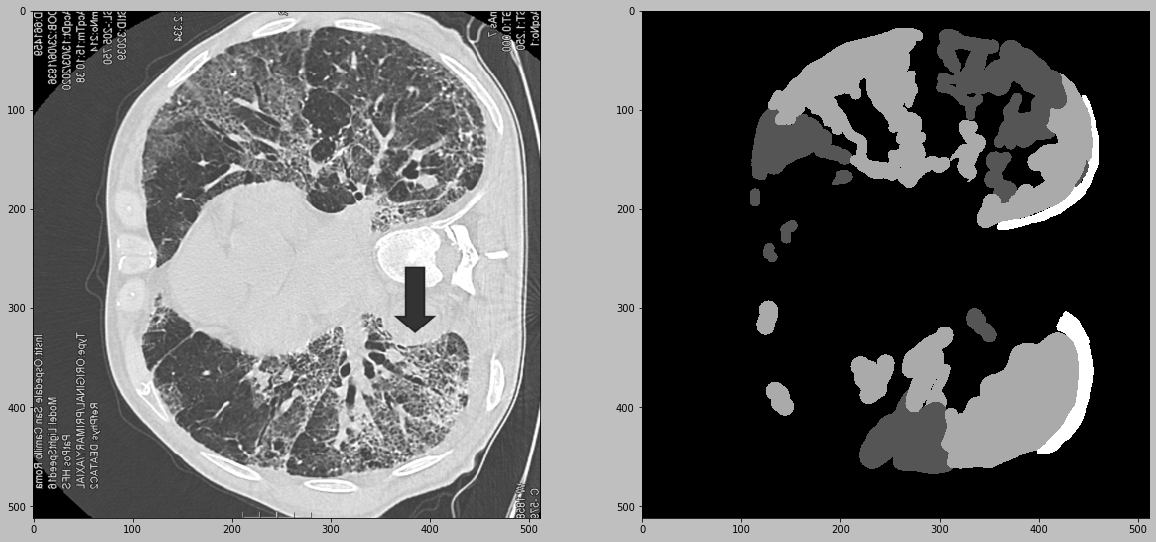

In [85]:
# Read the dataset consists of training set, masks of training set & testing set

os.chdir('D://covid data//CT_DICOM//')

train = nib.load('tr_im.nii')
train_data =train.get_fdata()
test = nib.load('val_im.nii')
test_data = test.get_fdata()
mask = nib.load('tr_mask.nii')
mask_data = mask.get_fdata()

print(train.shape)
print(test.shape)
print(mask.shape)

plt.figure(figsize = (20,10))
plt.style.use('grayscale')
plt.subplot(121)
plt.imshow(train_data[:,:,1]) 

plt.subplot(122)
plt.imshow(mask_data[:,:,1])


In [86]:
# HU images of training set

def transform_to_hu (train,img):
    intercept = train.dataobj.inter   # train.RescaleIntercept
    slope = train.dataobj.slope       # train.RescaleSlope
    hu_image = img*slope+intercept
    return (hu_image)

hu_image = transform_to_hu (train,train_data)

def window_image (img, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = img.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

In [88]:
# Obtain the area of infection in lungs via segmentation process

import cv2
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

def make_lungmask(img, display=True):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask

msk_inf = make_lungmask(hu_image[:,:,0], display=False)


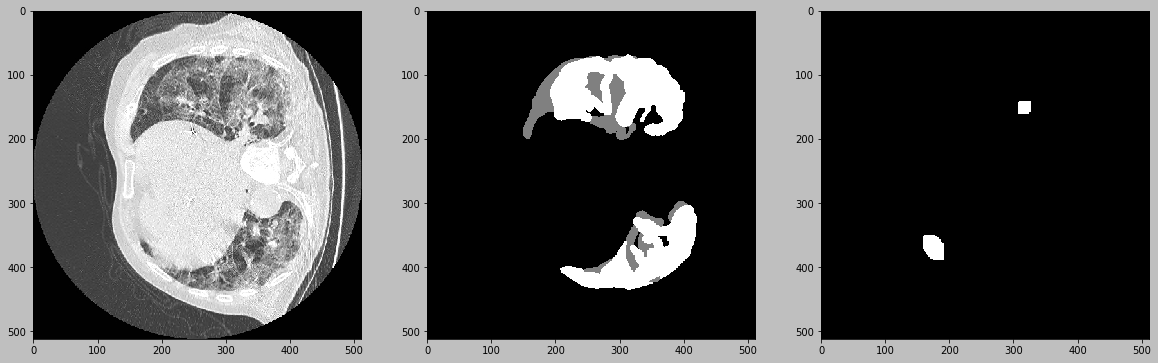

In [90]:
# example of first image of training set

plt.figure(figsize = (20,10))
plt.style.use('grayscale')
plt.subplot(131)
plt.imshow(train_data[:,:,0]) 

plt.subplot(132)
plt.imshow(mask_data[:,:,0])

plt.subplot(133)
plt.imshow(msk_inf)

In [91]:
# Rate of infection of first training image
img = mask_data[:,:,1]
sum_lung = np.sum(img > 0)
sum_inf = np.sum(msk > 0)
rate_of_infection = (sum_inf/sum_lung)*100
print(rate_of_infection)

4.831444229424487


In [92]:
# Rate of infection of all training image
for i in range (0,100):
    img = mask_data[:,:,i]
    msk = make_lungmask(hu_image[:,:,i], display=False)
    sum_lung = np.sum(img > 0)
    sum_inf = np.sum(msk > 0)
    rate_of_infection = (sum_inf/sum_lung)*100
    print(rate_of_infection)

4.113915206394455
7.408973379083799
4432.029339853301
9.080793719478272
20.72833435771358
64.88287126584999
7.92600391036246
13.572974803775754
1.1946027456279498
103.20357000326526
2.2754813518244243
243.8064884406812
304.700362199539
21.68792934249264
0.0
12.485047846889952
18.89725528297304
59.600443951165374
0.0
10.84446914391088
0.0
0.0
7271.428571428571
42.79836713702549
0.0
11.033727208701777
9.286582190591911
6.492922938665469
284.76587853500234
0.0
29.81694971282178
15.296160987003654
9.041335453100158
18.230016313213703
13.665620094191521
19.112545381202096
12.375621890547265
12.989535009170353
8.41546626231994
8.496348808698896
0.0
5.211563469040712
0.0
4.80225988700565
0.0
0.0
76.68393782383419
131.17423891921902


d:\phd\lekha\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


nan
439.0963341858482
21.69950408792387
6.549890052060819
670.2508178844057
0.0
73.56438319146062
119.26039588767838
20.07792207792208
0.0
1.0398560668435337
0.0
0.4308738240424612
7.485689123734038
895.7404795486601
27.541970224897057
0.0
32.3210131817007
0.0
5.6694908543827705
0.0
34.39481309349628
7.174606792796901
11.954428097209131
17.29027468448404
233.76001665105628
250.39494470774093
0.0
33.87812631200144
118.71230324130828
0.0
5.695707258905947
0.0
0.0
0.0
0.0
12.514551804423748
3.006500541711809
395.68408690546096
28.437243444245908
15.503262804034012
3242.5587467362925
24.581005586592177
45.85049294895794
10.815441991734705
43.641991230332735
14.874863982589773
356.658373706953
9.090360354922437
0.0
5.751173708920188
7.315013317741831
